# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-34-47/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4790 | MulticlassF1Score=0.1829
Batch-30 : CrossEntropyLoss=2.4827 | MulticlassF1Score=0.2184
Batch-45 : CrossEntropyLoss=2.4631 | MulticlassF1Score=0.2318
Batch-60 : CrossEntropyLoss=2.4623 | MulticlassF1Score=0.2442
Batch-75 : CrossEntropyLoss=2.4318 | MulticlassF1Score=0.2730
Batch-90 : CrossEntropyLoss=2.4072 | MulticlassF1Score=0.3051
Batch-105: CrossEntropyLoss=2.4106 | MulticlassF1Score=0.3298
Batch-120: CrossEntropyLoss=2.3811 | MulticlassF1Score=0.3528
Batch-135: CrossEntropyLoss=2.3951 | MulticlassF1Score=0.3763
Batch-150: CrossEntropyLoss=2.3596 | MulticlassF1Score=0.3980
Batch-165: CrossEntropyLoss=2.3652 | MulticlassF1Score=0.4147
Batch-180: CrossEntropyLoss=2.3713 | MulticlassF1Score=0.4298
Batch-195: CrossEntropyLoss=2.3811 | MulticlassF1Score=0.4421
Batch-210: CrossEntropyLoss=2.3695 | MulticlassF1Score=0.4531
Batch-225: CrossEntropyLoss=2.3518 | MulticlassF1Score=0.4627
Batch-226: CrossEntropyLoss=2.3701 | MulticlassF1Score=0.4631

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3747 | MulticlassF1Score=0.5969
Batch-30 : CrossEntropyLoss=2.3732 | MulticlassF1Score=0.5935
Batch-45 : CrossEntropyLoss=2.3626 | MulticlassF1Score=0.5985
Batch-60 : CrossEntropyLoss=2.3593 | MulticlassF1Score=0.5985
Batch-63 : CrossEntropyLoss=2.3661 | MulticlassF1Score=0.5987

Training   : Mean CrossEntropyLoss = 2.4253 | Mean MulticlassF1Score = 0.3313
Validation : Mean CrossEntropyLoss = 2.3722 | Mean MulticlassF1Score = 0.5973

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3758 | MulticlassF1Score=0.5988
Batch-30 : CrossEntropyLoss=2.3638 | MulticlassF1Score=0.5976
Batch-45 : CrossEntropyLoss=2.3584 | MulticlassF1Score=0.6108
Batch-60 : CrossEntropyLoss=2.3376 | MulticlassF1Score=0.6250
Batch-75 : CrossEntropyLoss=2.3450 | MulticlassF1Score=0.6337
Batch-90 : CrossEntropyLoss=2.3413 | MulticlassF1Score=0.6407
Batch-105: CrossEntropyLoss=2.3526 | MulticlassF1Score=0.6465
Batch-120: CrossEntropyLoss=2.3348 | MulticlassF1Score=0.6524
Batch-135: CrossEntropyLoss=2.3458 | MulticlassF1Score=0.6588
Batch-150: CrossEntropyLoss=2.3301 | MulticlassF1Score=0.6646
Batch-165: CrossEntropyLoss=2.3440 | MulticlassF1Score=0.6693
Batch-180: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.6735
Batch-195: CrossEntropyLoss=2.3325 | MulticlassF1Score=0.6770
Batch-210: CrossEntropyLoss=2.3422 | MulticlassF1Score=0.6800
Batch-225: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.6828
Batch-226: CrossEntropyLoss=2.3320 | MulticlassF1Score=0.6829

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3267 | MulticlassF1Score=0.7261
Batch-30 : CrossEntropyLoss=2.3292 | MulticlassF1Score=0.7278
Batch-45 : CrossEntropyLoss=2.3248 | MulticlassF1Score=0.7236
Batch-60 : CrossEntropyLoss=2.3376 | MulticlassF1Score=0.7243
Batch-63 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3470 | Mean MulticlassF1Score = 0.6447
Validation : Mean CrossEntropyLoss = 2.3334 | Mean MulticlassF1Score = 0.7231

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3482 | MulticlassF1Score=0.7244
Batch-30 : CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7273
Batch-45 : CrossEntropyLoss=2.3329 | MulticlassF1Score=0.7251
Batch-60 : CrossEntropyLoss=2.3260 | MulticlassF1Score=0.7270
Batch-75 : CrossEntropyLoss=2.3348 | MulticlassF1Score=0.7274
Batch-90 : CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7286
Batch-105: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.7322
Batch-120: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7375
Batch-135: CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7409
Batch-150: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.7460
Batch-165: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7506
Batch-180: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.7548
Batch-195: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7582
Batch-210: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7613
Batch-225: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.7649
Batch-226: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.7650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.8192
Batch-30 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8219
Batch-45 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8202
Batch-60 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8221
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3213 | Mean MulticlassF1Score = 0.7396
Validation : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8213

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8239
Batch-30 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8285
Batch-45 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8289
Batch-75 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8287
Batch-90 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8278
Batch-105: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8284
Batch-120: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8296
Batch-135: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8293
Batch-150: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8298
Batch-165: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8296
Batch-180: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8297
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8302
Batch-210: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8306
Batch-225: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8309
Batch-226: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8309

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8309
Batch-30 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8337
Batch-45 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8343
Batch-60 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8347
Batch-63 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8346

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8288
Validation : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8329

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8371
Batch-30 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8394
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8393
Batch-60 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8400
Batch-75 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8389
Batch-90 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8387
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8390
Batch-120: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8389
Batch-135: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8385
Batch-150: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8389
Batch-165: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8385
Batch-180: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8381
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8374
Batch-210: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8379
Batch-225: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8379
Batch-226: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8397
Batch-30 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8384
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8380
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8379
Batch-63 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8385
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8386

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8390
Batch-45 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8385
Batch-60 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8403
Batch-75 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8414
Batch-90 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8418
Batch-105: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8409
Batch-120: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8415
Batch-135: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8409
Batch-150: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8413
Batch-165: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8404
Batch-180: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8402
Batch-195: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8399
Batch-210: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8398
Batch-225: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8399
Batch-226: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8368
Batch-30 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8373
Batch-45 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8372
Batch-60 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8376
Batch-63 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8406
Validation : Mean CrossEntropyLoss = 2.2980 | Mean MulticlassF1Score = 0.8366

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8430
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8428
Batch-45 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8437
Batch-60 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8430
Batch-75 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8412
Batch-90 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8407
Batch-105: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8413
Batch-120: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8413
Batch-135: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8407
Batch-150: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8407
Batch-165: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8405
Batch-180: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8414
Batch-195: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8426
Batch-210: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8438
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8443
Batch-226: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8527
Batch-30 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8542
Batch-45 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8545
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8536
Batch-63 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8529

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8417
Validation : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8534

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8608
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8611
Batch-45 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8590
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8587
Batch-75 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8590
Batch-90 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8589
Batch-105: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8597
Batch-120: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8605
Batch-135: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8602
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8600
Batch-165: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8599
Batch-180: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8595
Batch-195: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8590
Batch-210: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8591
Batch-225: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8590
Batch-226: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8589

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8528
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8560
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8554
Batch-60 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8555
Batch-63 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8555

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2916 | Mean MulticlassF1Score = 0.8594
Validation : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8559

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8562
Batch-30 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8604
Batch-45 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8618
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8604
Batch-75 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8603
Batch-90 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8615
Batch-105: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8611
Batch-120: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8610
Batch-135: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8610
Batch-150: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8608
Batch-165: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8610
Batch-180: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8611
Batch-195: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8612
Batch-210: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8610
Batch-225: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8605
Batch-226: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8606

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8565
Batch-30 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8578
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8561
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8558
Batch-63 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8560

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2909 | Mean MulticlassF1Score = 0.8608
Validation : Mean CrossEntropyLoss = 2.2923 | Mean MulticlassF1Score = 0.8569

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8632
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8613
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8598
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8601
Batch-75 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8599
Batch-90 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8610
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8613
Batch-120: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8611
Batch-135: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8613
Batch-150: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8619
Batch-165: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8618
Batch-180: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8615
Batch-195: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8619
Batch-210: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8617
Batch-225: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8621
Batch-226: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8621

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8569
Batch-30 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8600
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8600
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8607
Batch-63 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8606

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2904 | Mean MulticlassF1Score = 0.8615
Validation : Mean CrossEntropyLoss = 2.2910 | Mean MulticlassF1Score = 0.8594

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8716
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8696
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8686
Batch-60 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8690
Batch-75 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8694
Batch-90 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8691
Batch-105: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8695
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8695
Batch-135: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8698
Batch-150: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8695
Batch-165: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8693
Batch-180: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8694
Batch-195: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8690
Batch-210: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8690
Batch-225: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8688
Batch-226: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8614
Batch-30 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8600
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8618
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8620
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8622

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2884 | Mean MulticlassF1Score = 0.8697
Validation : Mean CrossEntropyLoss = 2.2902 | Mean MulticlassF1Score = 0.8622

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8748
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8696
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8697
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8704
Batch-75 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8701
Batch-90 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8699
Batch-105: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8707
Batch-120: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8708
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8705
Batch-150: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8707
Batch-165: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8707
Batch-180: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8705
Batch-195: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8705
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8707
Batch-225: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8712
Batch-226: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8621
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8620
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8621
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8638
Batch-63 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8637

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2876 | Mean MulticlassF1Score = 0.8709
Validation : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8633

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8757
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8758
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8736
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8736
Batch-75 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8744
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8747
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8745
Batch-120: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8748
Batch-135: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8748
Batch-150: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8744
Batch-165: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8740
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8738
Batch-195: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8735
Batch-210: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8734
Batch-225: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8730
Batch-226: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8730

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8648
Batch-30 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8653
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8634
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8628
Batch-63 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8628

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8741
Validation : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8640

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8715
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8761
Batch-45 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8744
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8738
Batch-75 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8737
Batch-90 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8742
Batch-105: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8742
Batch-120: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8740
Batch-135: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8744
Batch-150: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8743
Batch-165: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8739
Batch-180: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8740
Batch-195: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8738
Batch-210: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8741
Batch-225: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8742
Batch-226: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8742

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8613
Batch-30 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8660
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8649
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8643
Batch-63 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8645

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2865 | Mean MulticlassF1Score = 0.8740
Validation : Mean CrossEntropyLoss = 2.2894 | Mean MulticlassF1Score = 0.8641

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8820
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8858
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8919
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8940
Batch-90 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8946
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8954
Batch-120: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8961
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8985
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9012
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9029
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9053
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9071
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9087
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9100
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9100

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9206
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9191
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9189

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.8967
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9221

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9315
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9313
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9309
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9309
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9317
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9318
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9319
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9319
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9321
Batch-165: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9319
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9318
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9323
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9321
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9218

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9368
Batch-90 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9368
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9361
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9358
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9359
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9360
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9354
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9352
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9352
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9228

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9387
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9379
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9377
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9233

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9237

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9388
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9391
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9228

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9408
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9250

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9230

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9434
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9263

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9440
Batch-210: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9250

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9256

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9270

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9442
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9273

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9283
Patience = 1/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9454
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9277

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9466
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9457
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9463
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9247

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9466
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9317
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9300

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9285

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9482
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9477
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9268
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9264

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9477
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9278

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9481
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9470
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9286

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9265
Patience = 2/50❗

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9490
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9487
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9478
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9477
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9306
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9287

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9486
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9285

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9480
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9483
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9479
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9480
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9286

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9484
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9485
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9483
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9480
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9309
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9289
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9297

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9504
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9495
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9491
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9490
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9487
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9489
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9488
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9484
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9485

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9302

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9505
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9500
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9495
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9492
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9490
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9489
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9486
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9486
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9486

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9312
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9297
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9295
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9493
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9310

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9499
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9491
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9496
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9491
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9493
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9495
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9491
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9492
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9492
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9491
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9489
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9489

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9303
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9297
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9289
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9496
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9308

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9509
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9509
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9507
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9503
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9500
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9502
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9504
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9502
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9499
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9499
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9498

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9507
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9291

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9484
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9483
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9486
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9485
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9248

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9258
Patience = 3/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9295
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9294

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9320
Patience = 4/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9508
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9507
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9270

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9279
Patience = 5/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9455
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9459
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9283

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9490
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9490
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9495
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9493
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9496
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9494
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9494
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9488
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9489
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9489
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9490
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9492
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9493

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9297
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9295

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9293

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9544
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9523
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9525
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9520
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9518
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9512
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9513
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9515
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9514
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9509
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9509
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9512
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9512
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9508
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9508

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9300
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9298
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9297
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9298

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9517
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9304

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9512
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9516
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9519
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9523
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9526
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9526
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9525
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9521
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9520
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9520
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9518
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9518
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9516
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9516

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9295
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9302

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9517
Validation : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9290

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9519
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9523
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9517
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9517
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9517
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9518
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9528
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9540
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9554
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9569
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9580
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9538
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9452

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9714
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9714
Batch-226: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9714

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9528
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9510
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9526

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9728
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9717
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9724
Batch-105: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9724
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9725
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9725
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9728
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9725
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9720
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9721
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9720
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9723
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9464

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9723
Best MulticlassF1Score validation : 0.9464
Training duration                 : 2.7097 minutes.
Training date                     : 2022-10-19 14:06:56.870874+08:00


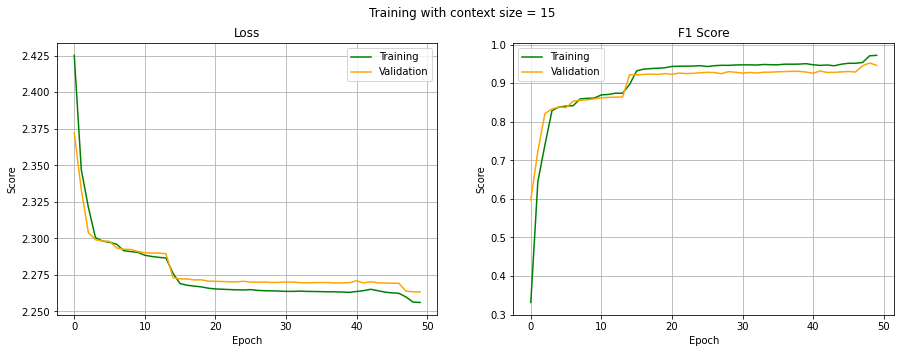

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9455, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9724, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9455, device='cuda:0'))

## Heatmap

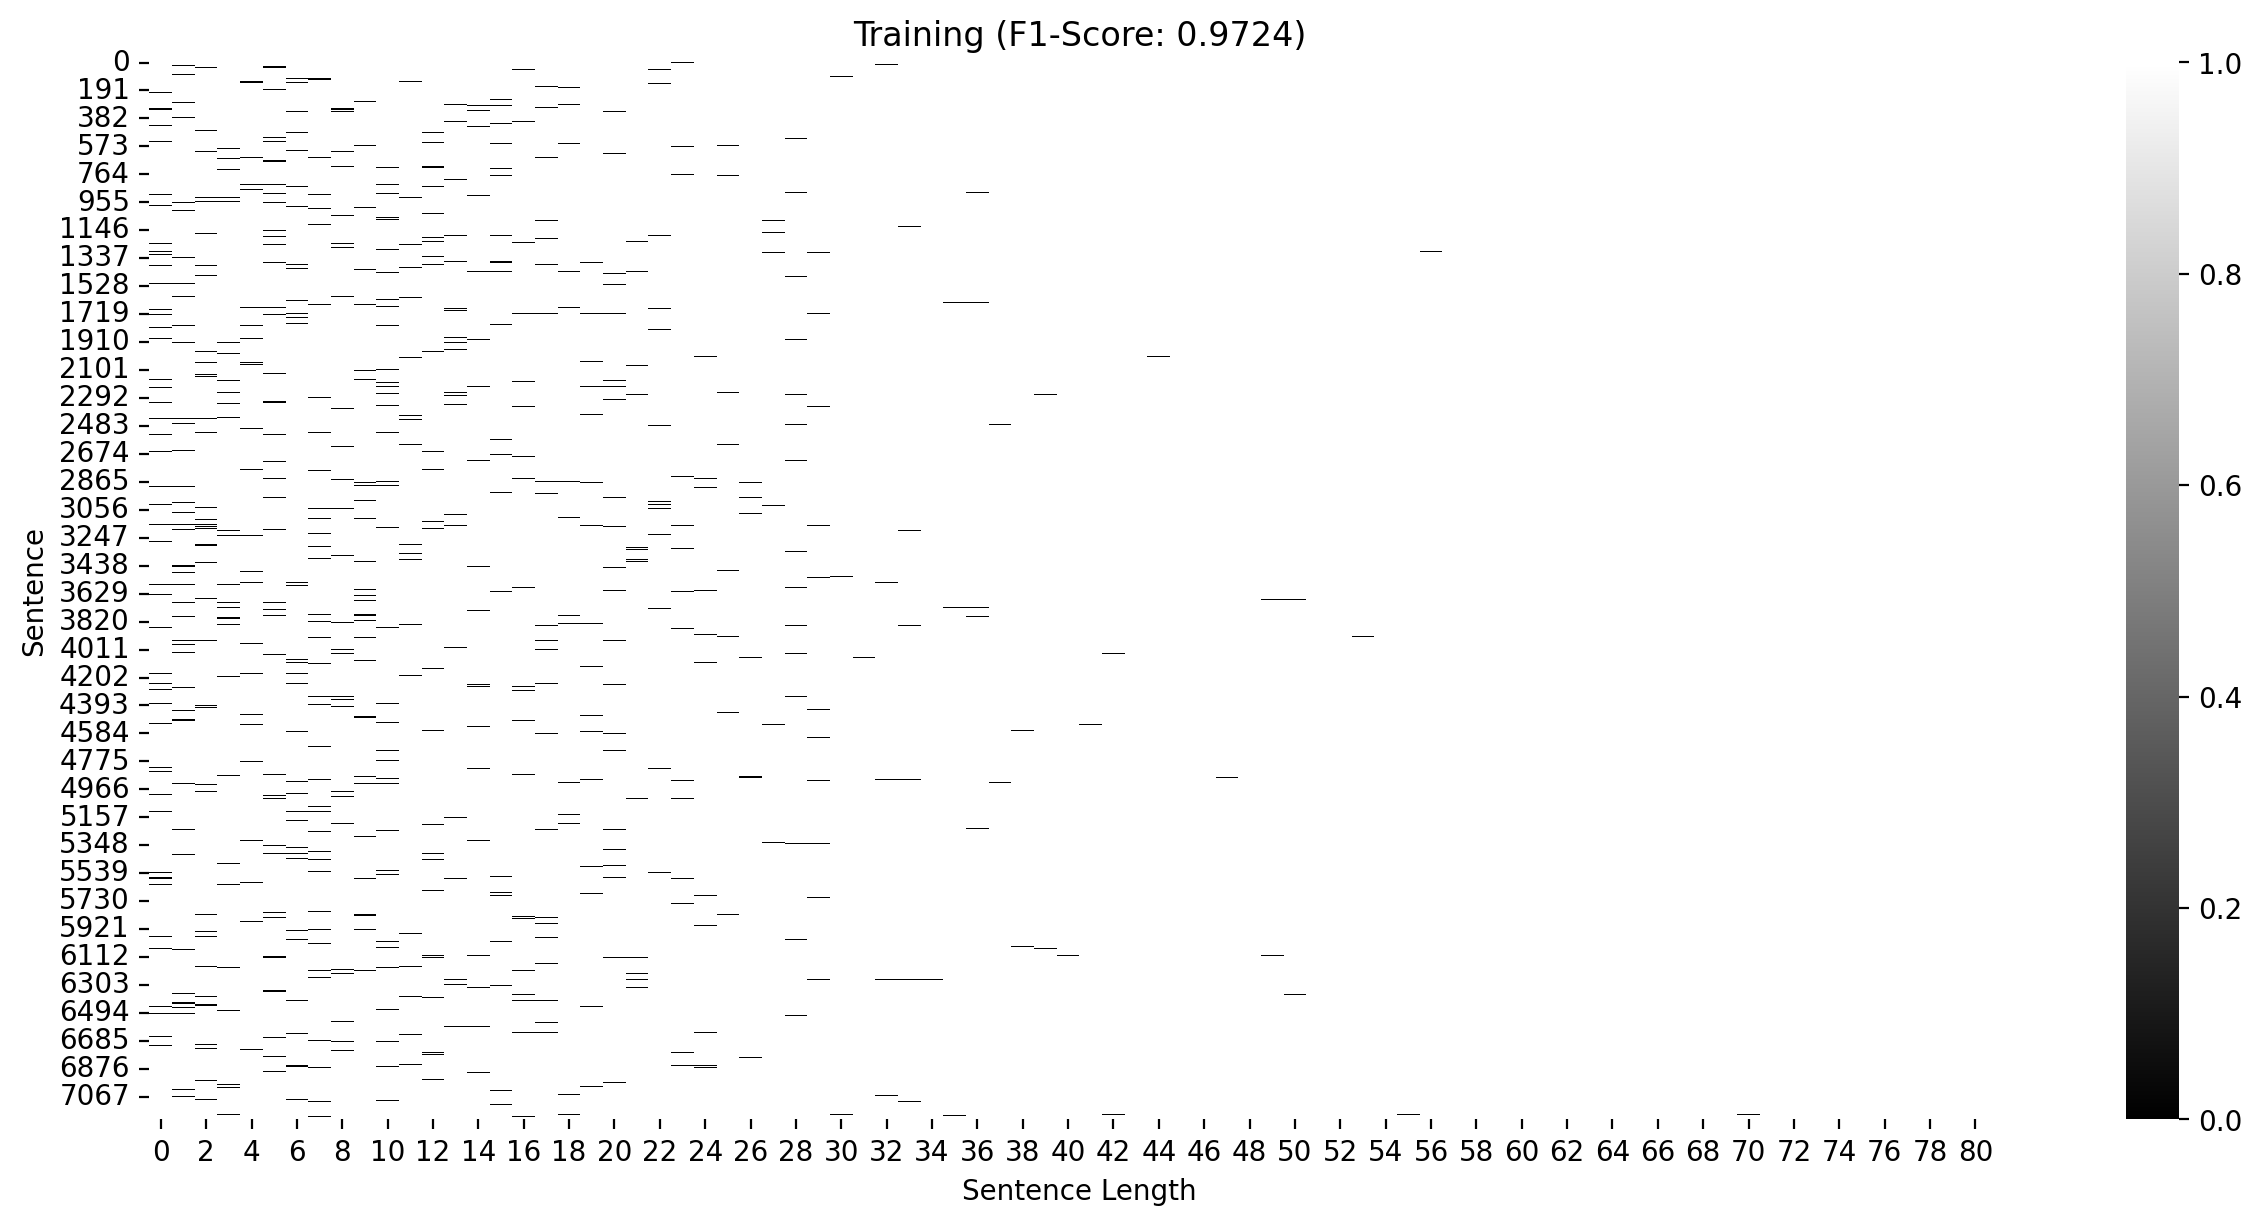

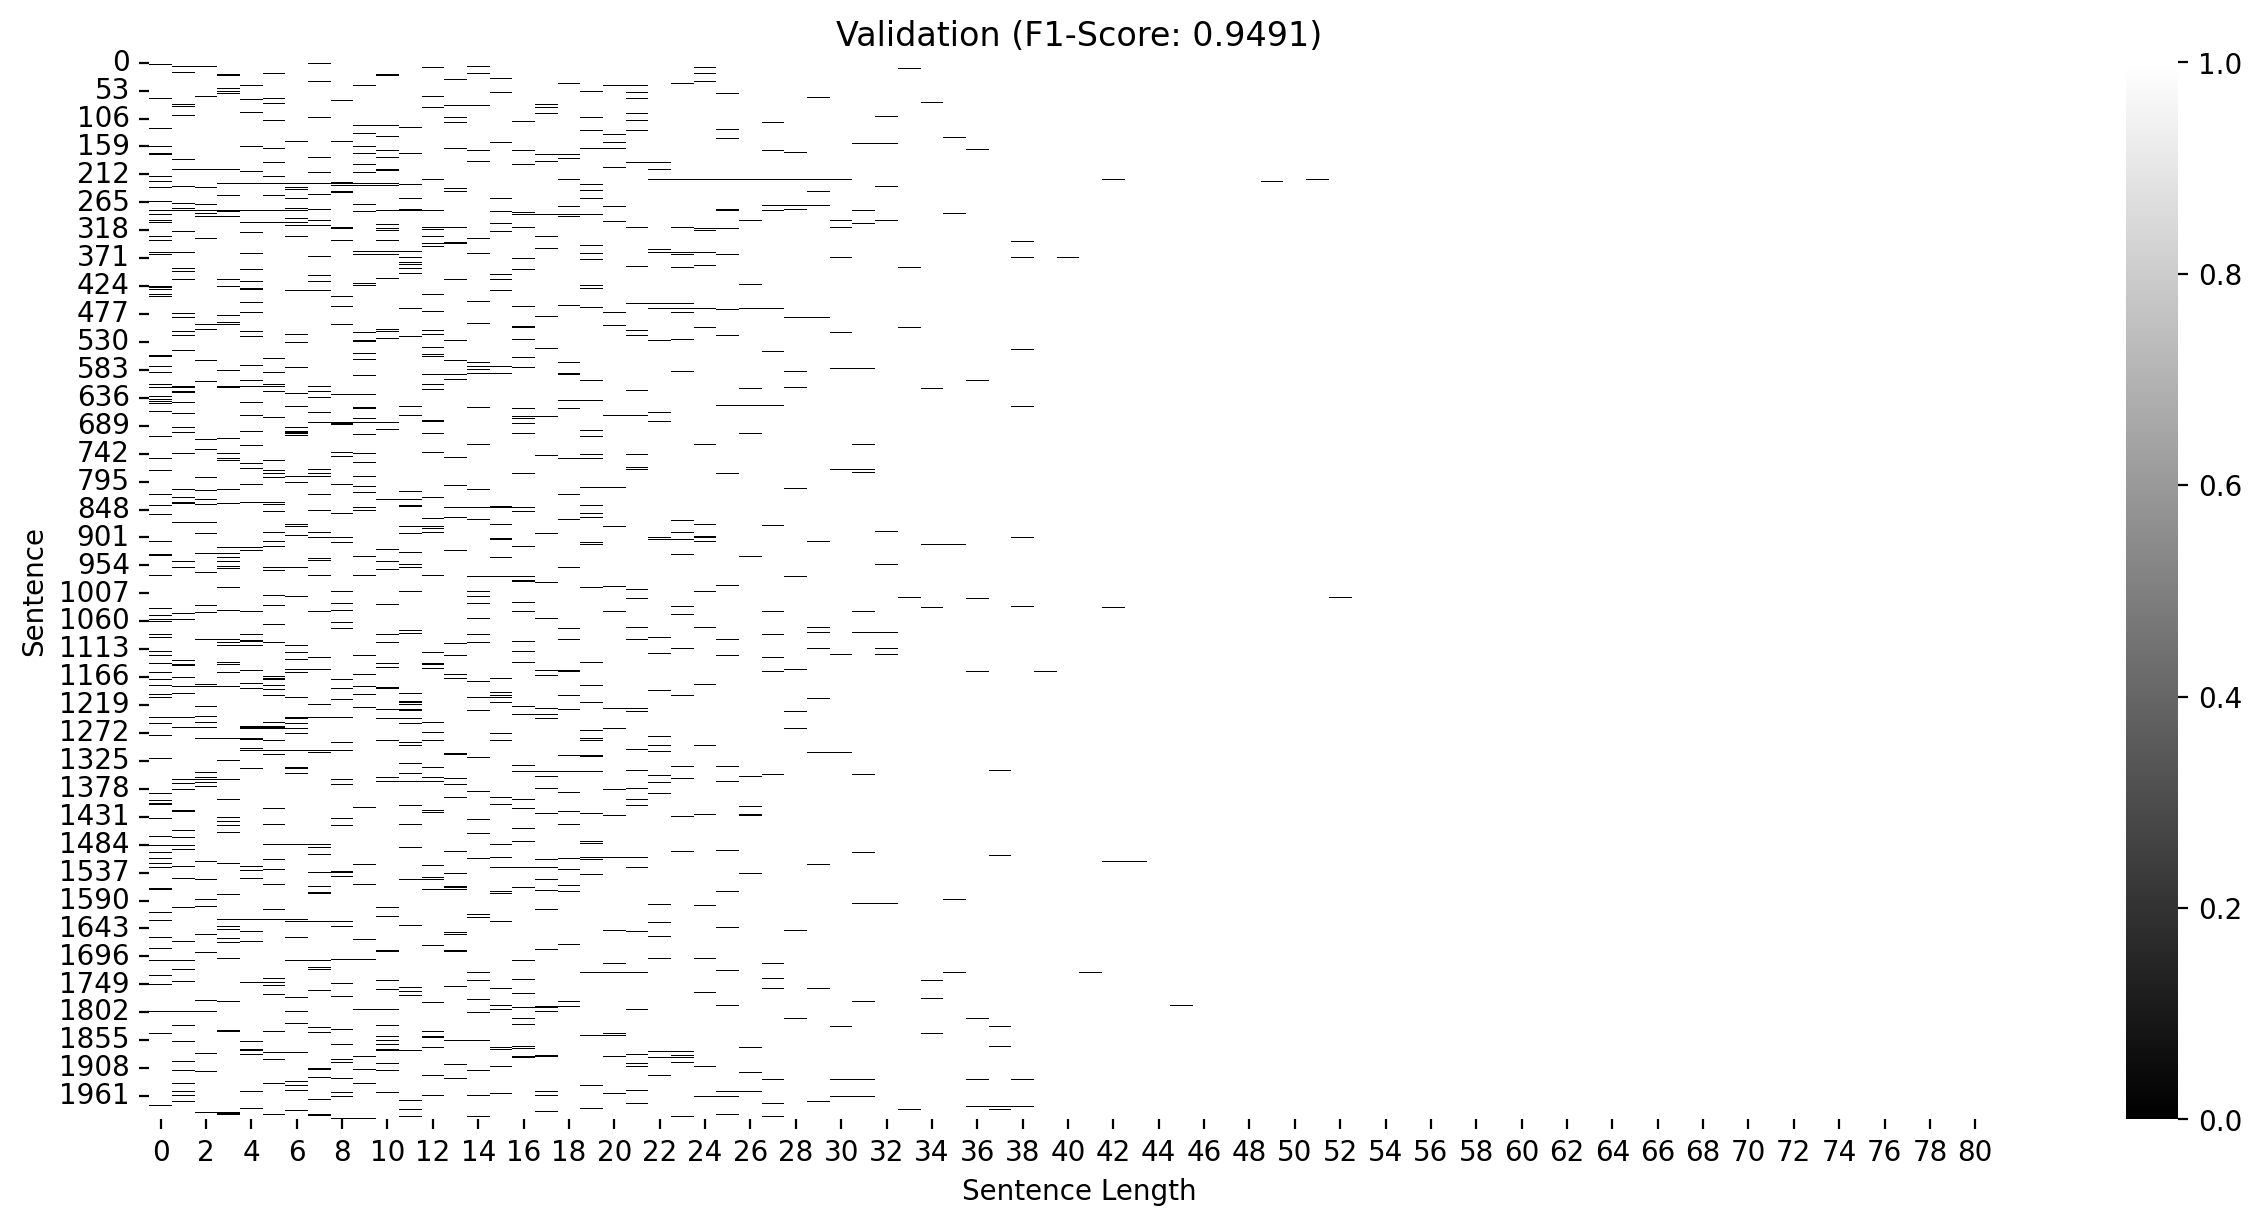

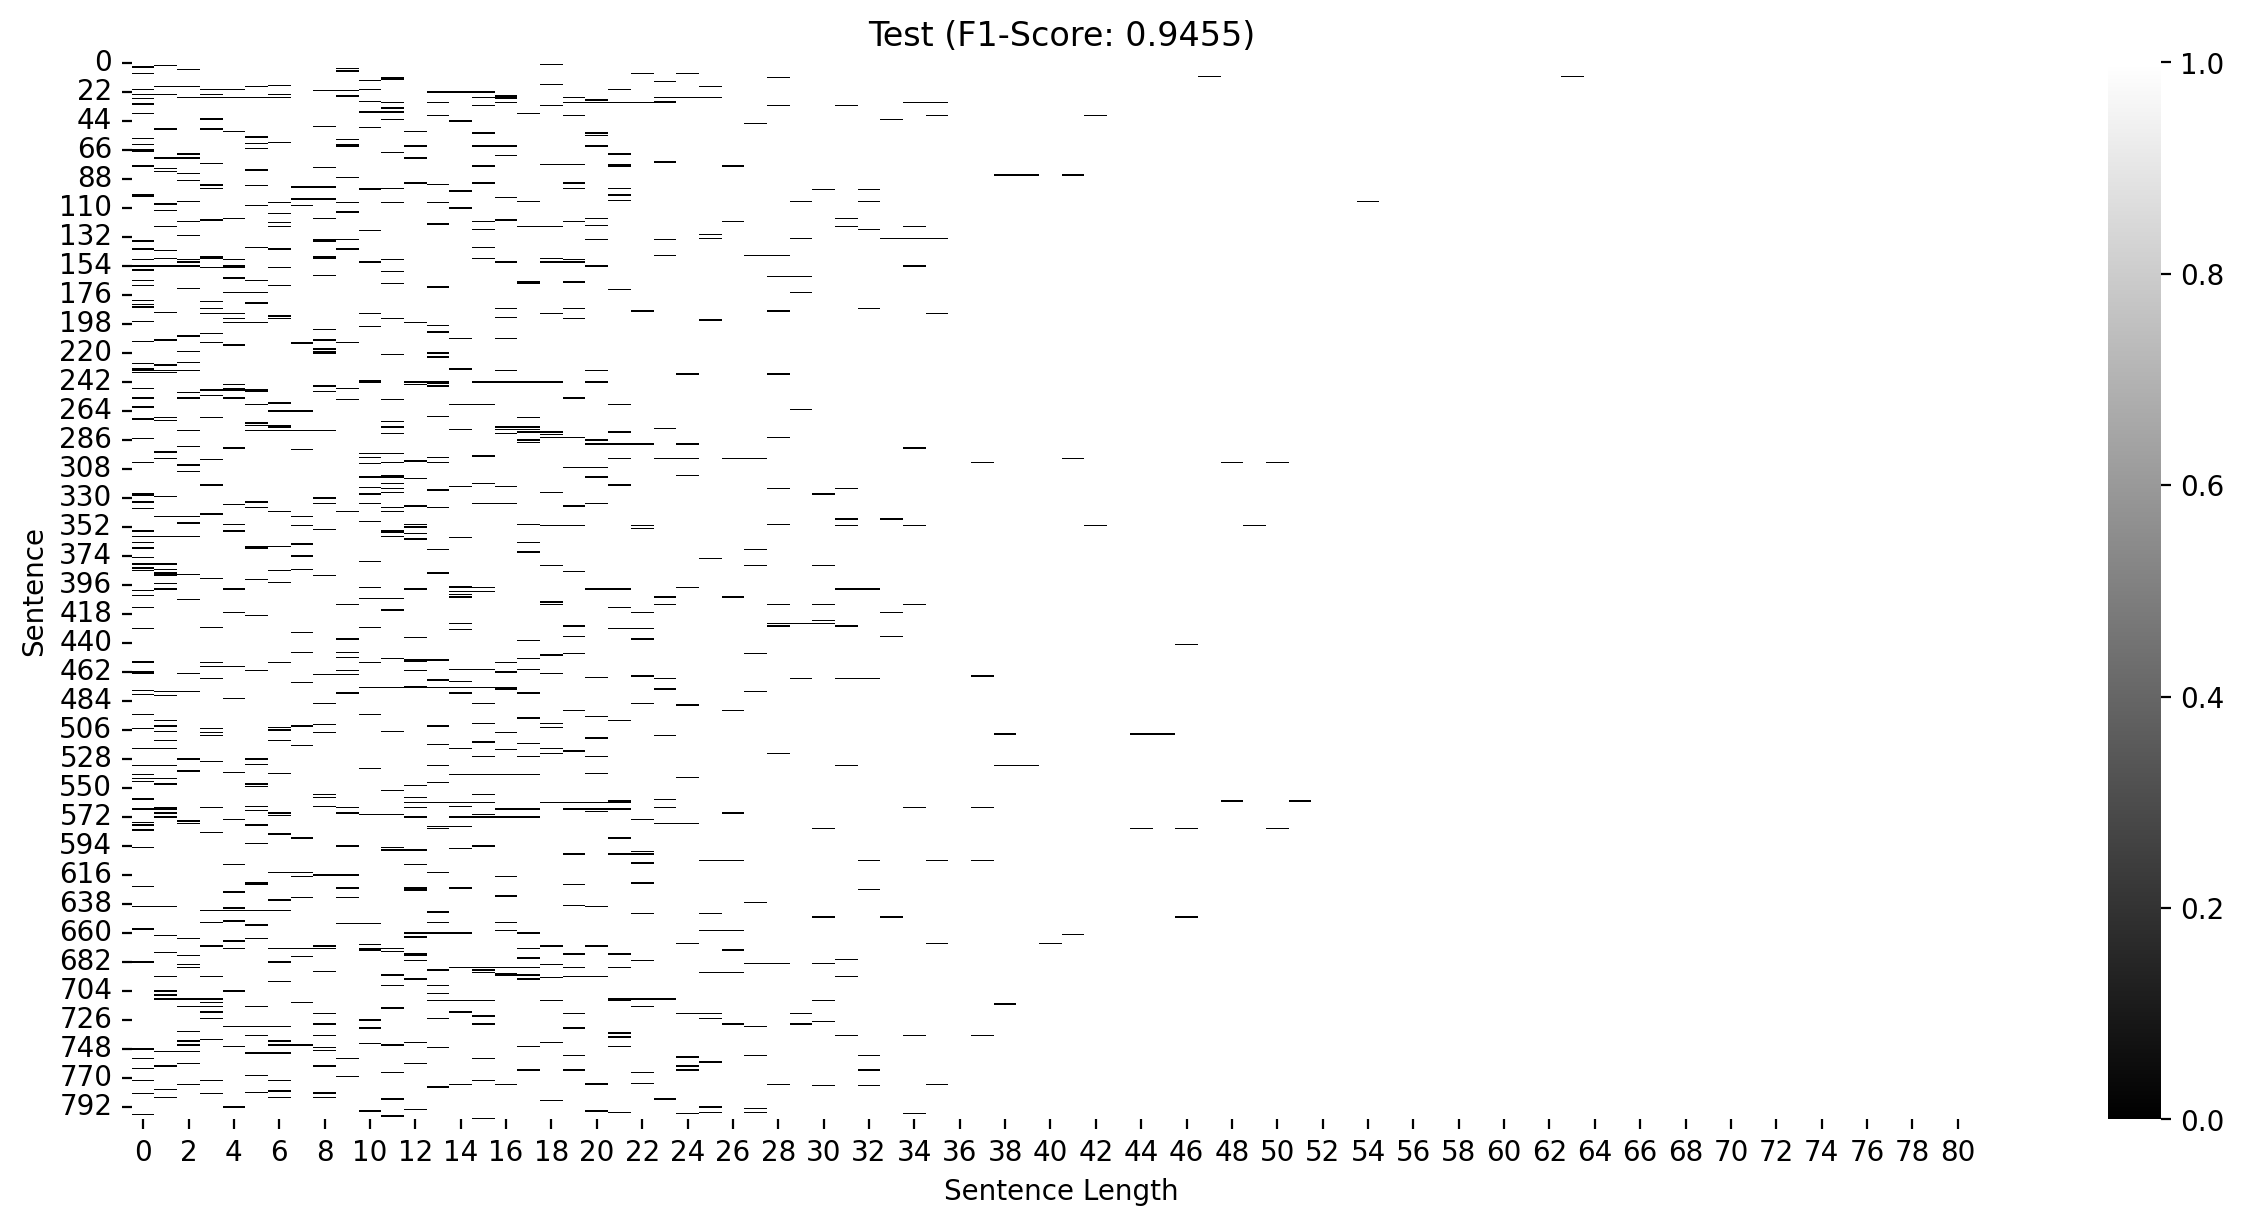

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


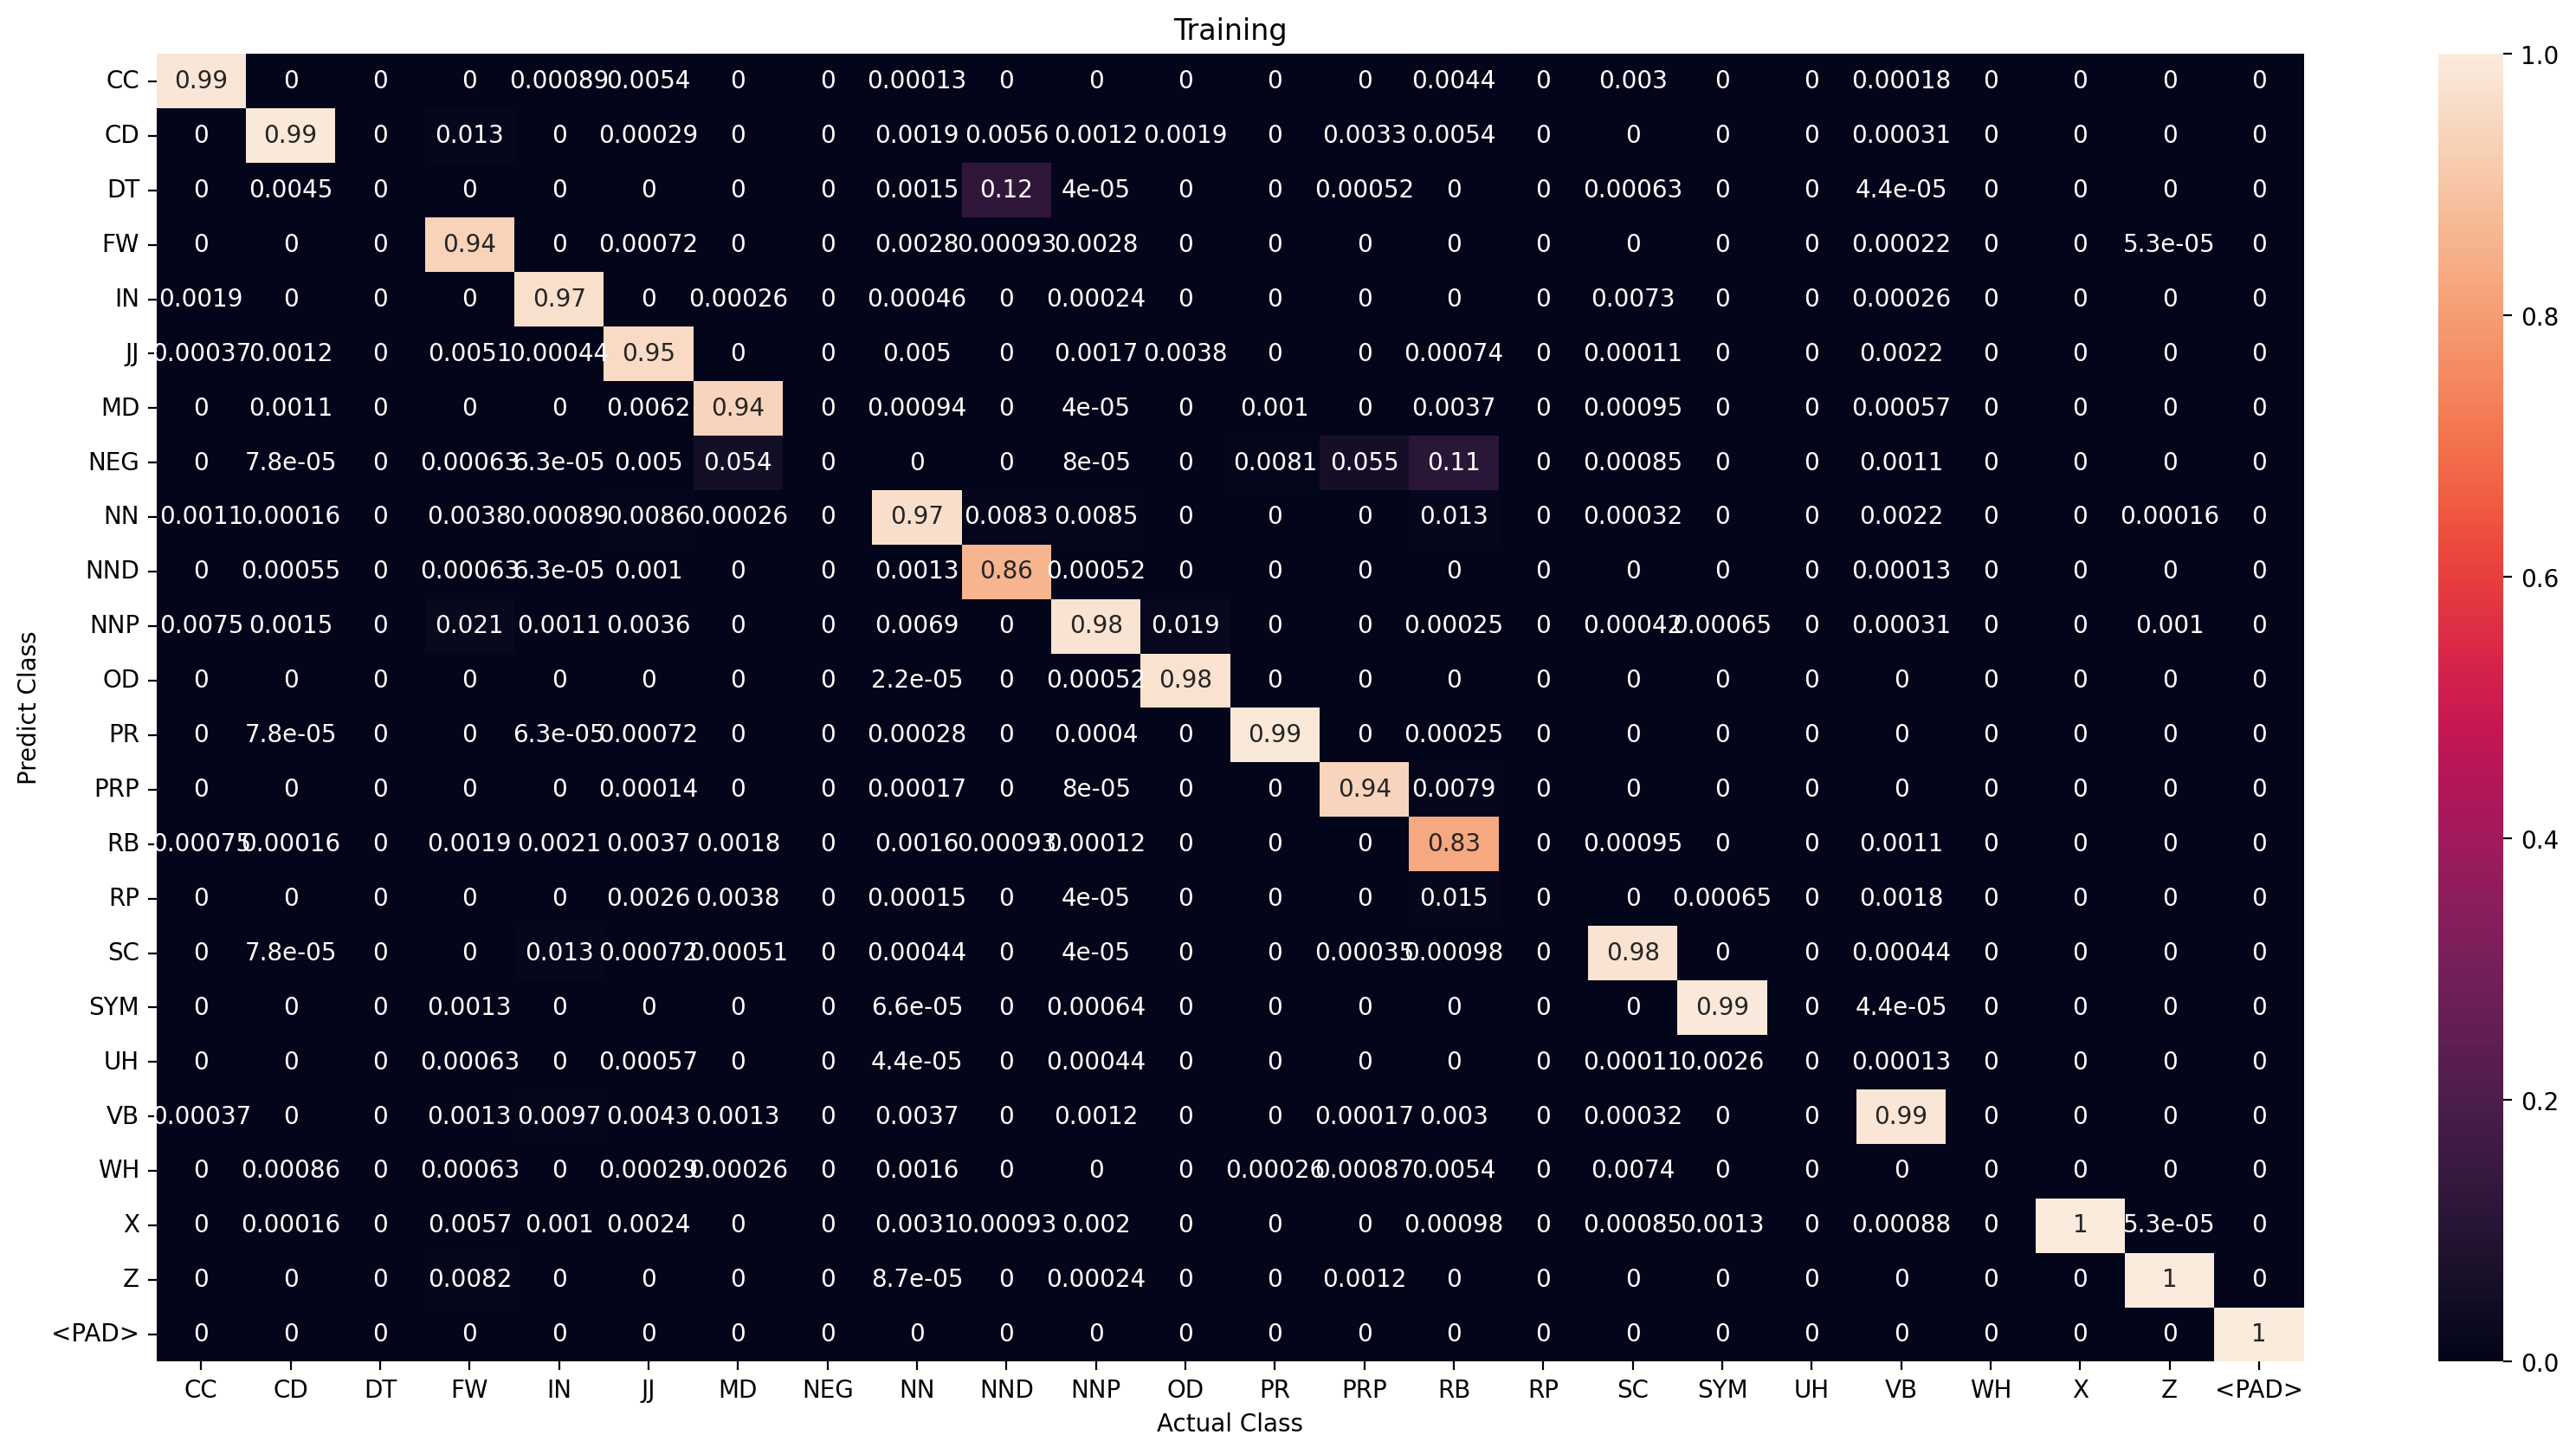

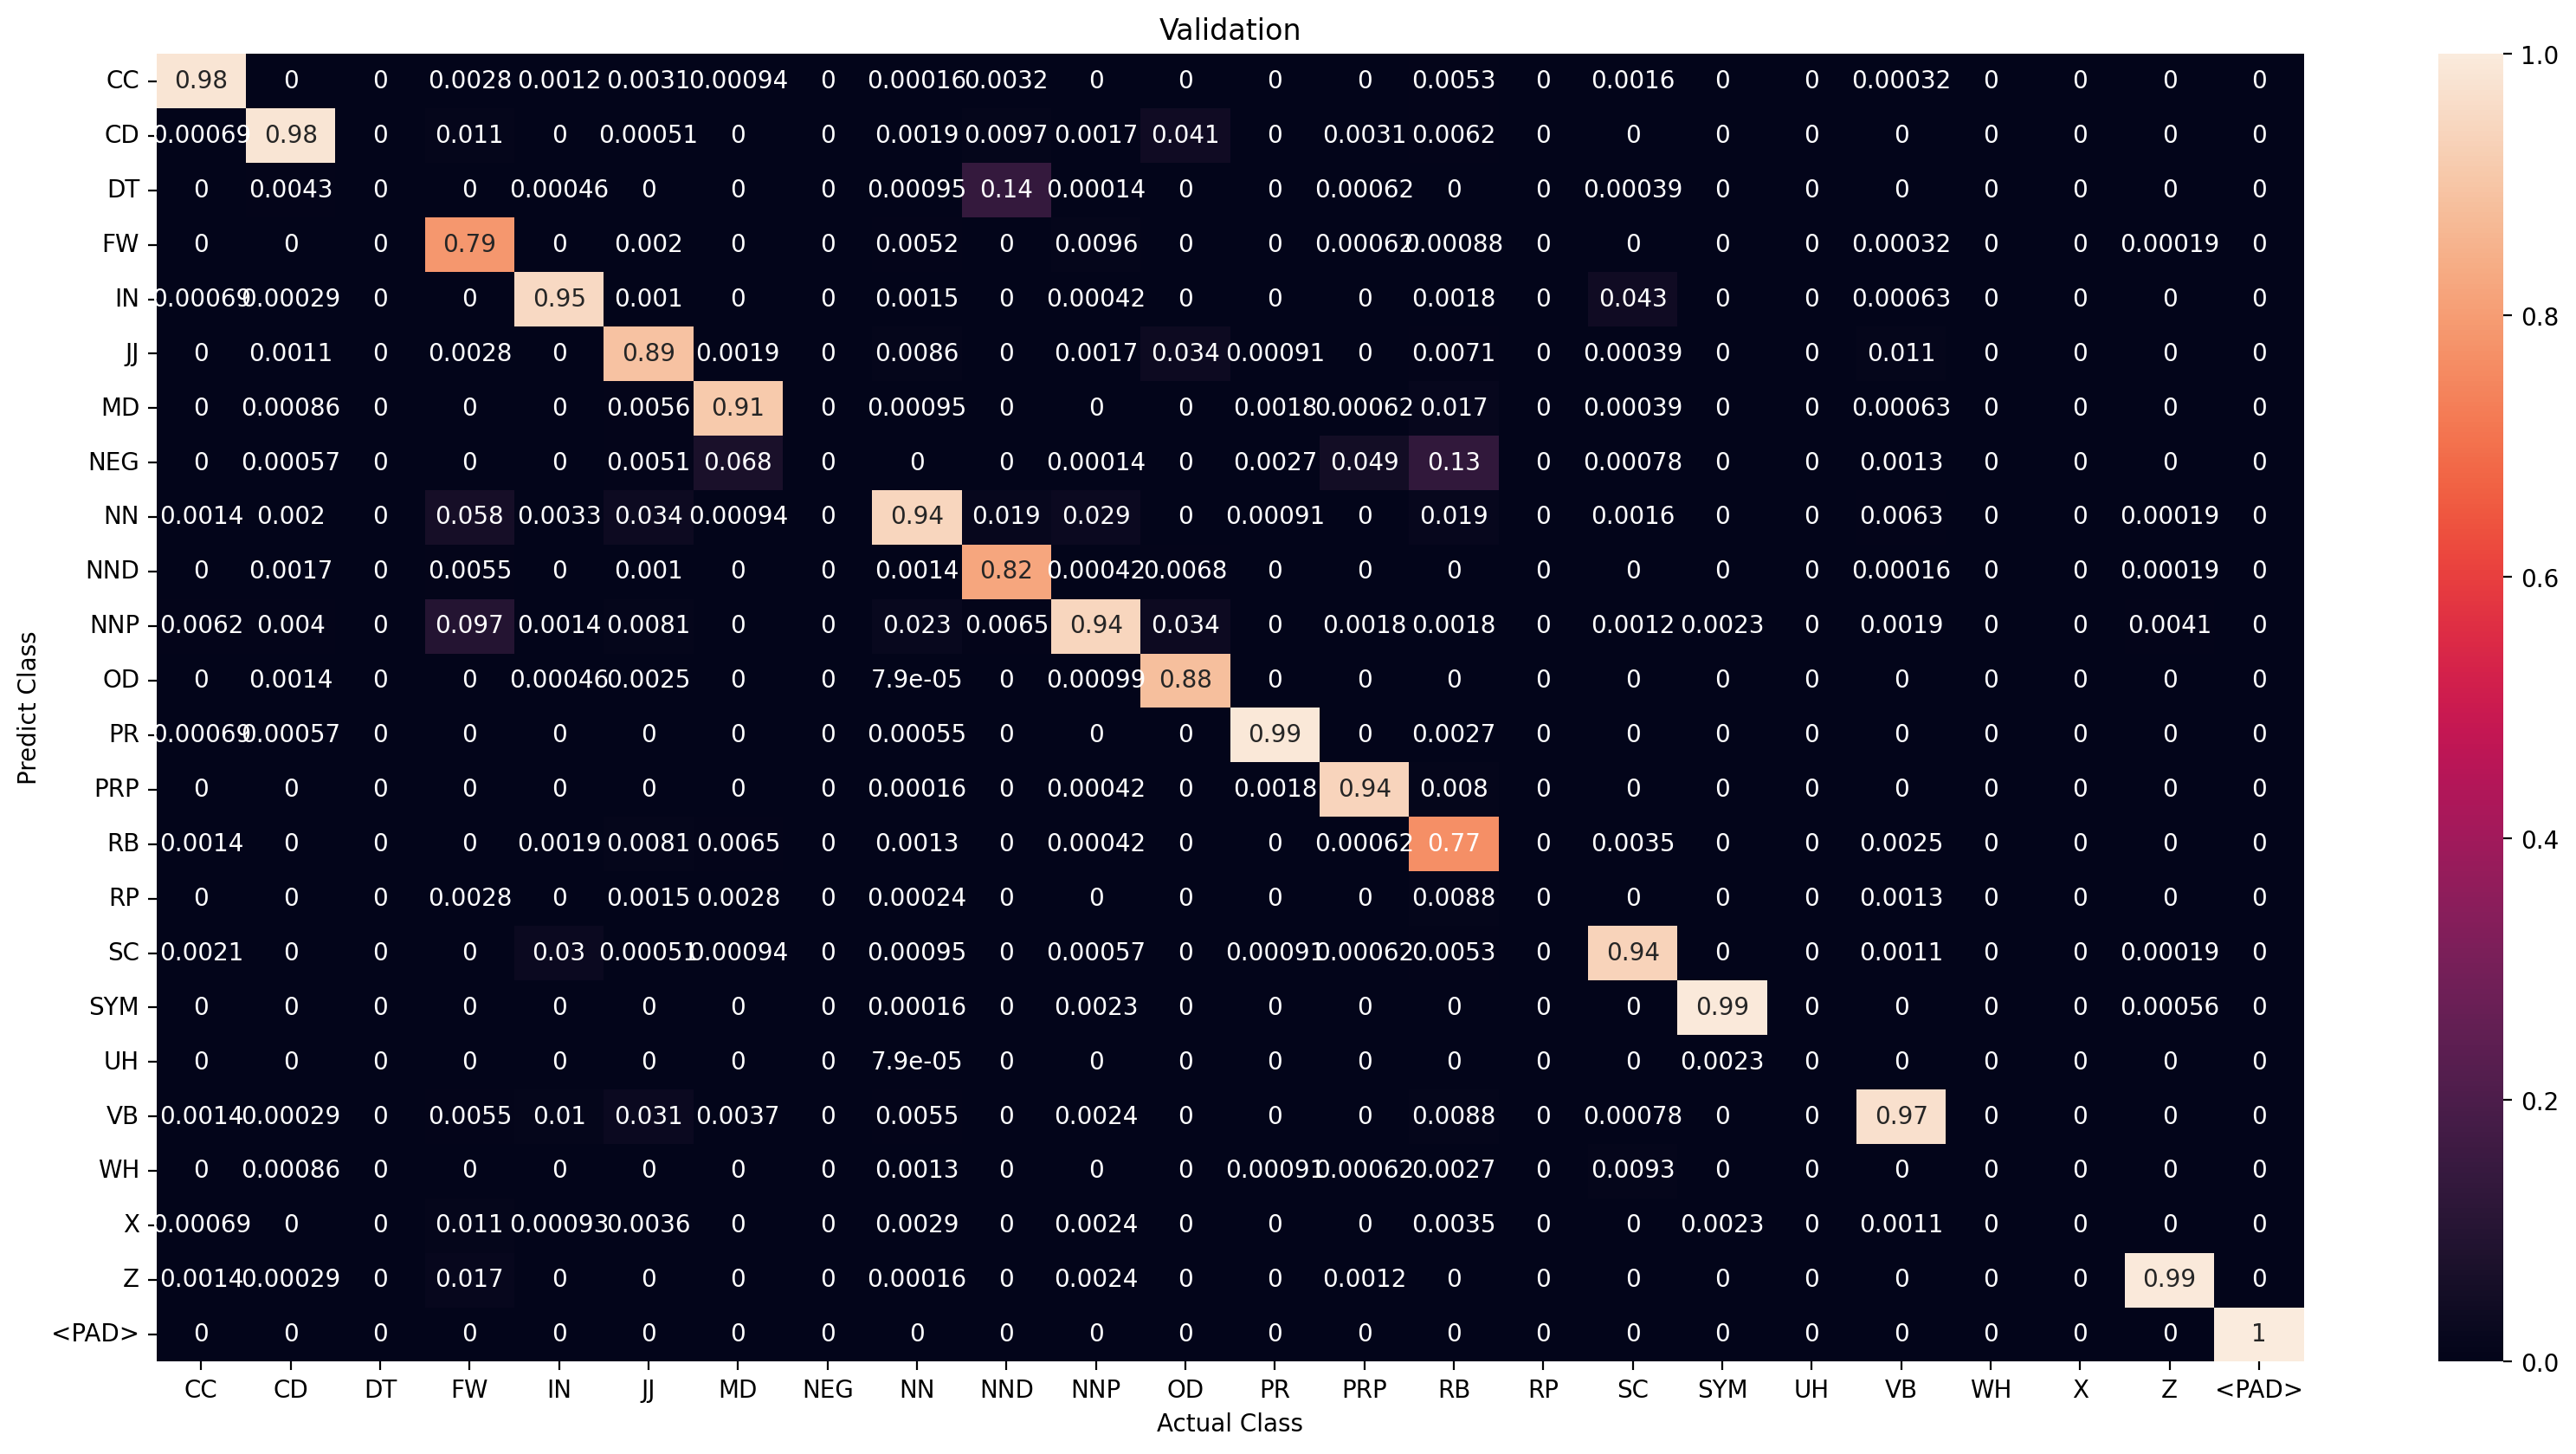

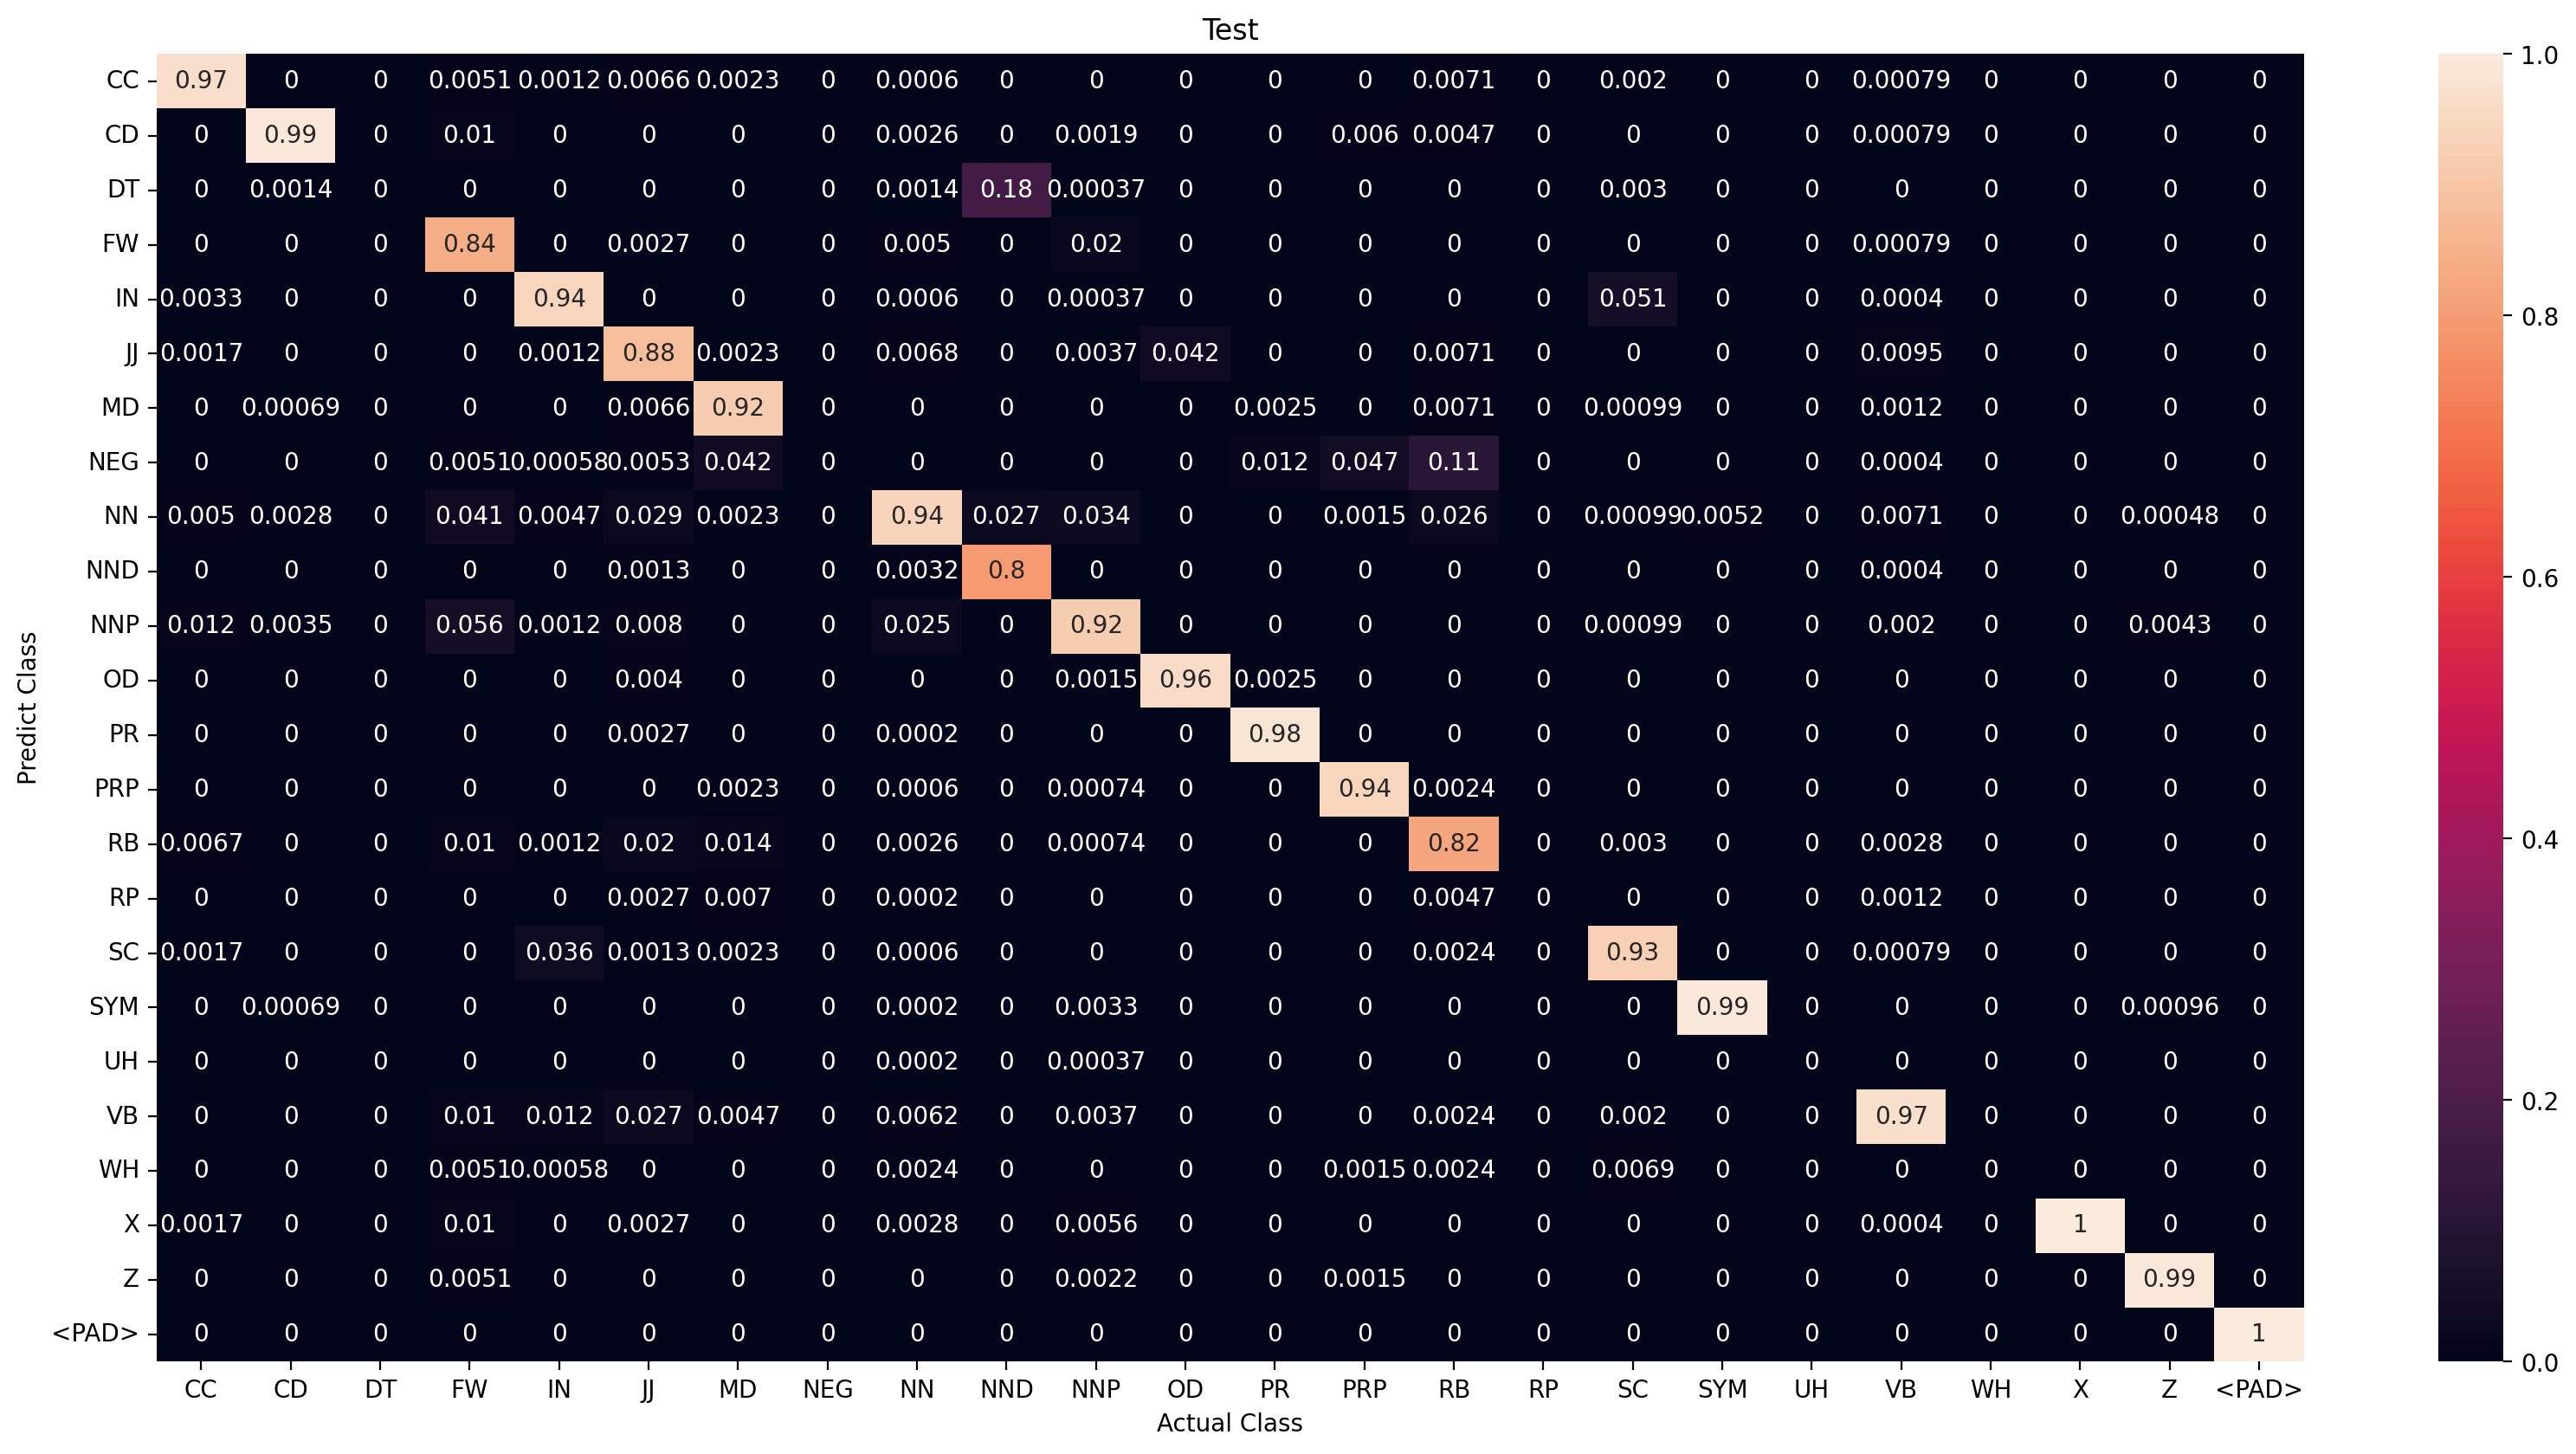

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5283       | CC    : 108      |
| CD    : 12882  | CD    : 12686      | CD    : 196      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1479       | FW    : 211      |
| IN    : 15403  | IN    : 15290      | IN    : 113      |
| JJ    : 7018   | JJ    : 6658       | JJ    : 360      |
| MD    : 3810   | MD    : 3668       | MD    : 142      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44308      | NN    : 420      |
| NND   : 1019   | NND   : 927        | NND   : 92       |
| NNP   : 24885  | NNP   : 24392      | NNP   : 493      |
| OD    : 534    | OD    : 520        | OD    : 14       |
| PR    : 3842   | PR    : 3811       | PR    : 31       |
| PRP   : 5405   | PRP   : 5362       | PRP   : 43       |
| RB    : 3553   | RB    : 3367       | RB    : 186      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11051
Wrong prediction            : 757
Percentage correct oov pred : 93.58909214092141

Validation
Number OOV token            : 3395
Correct prediction          : 3011
Wrong prediction            : 384
Percentage correct oov pred : 88.68924889543446

Test
Number OOV token            : 1359
Correct prediction          : 1189
Wrong prediction            : 170
Percentage correct oov pred : 87.49080206033848



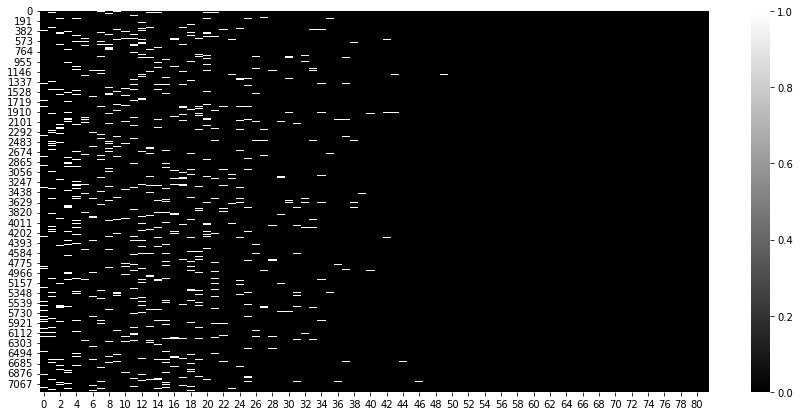

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

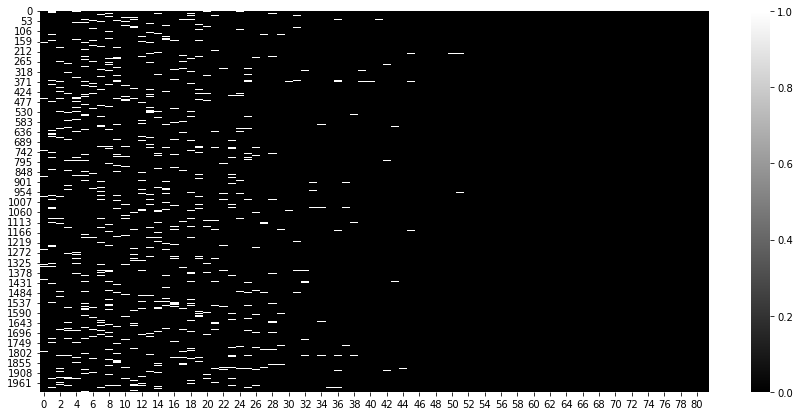

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

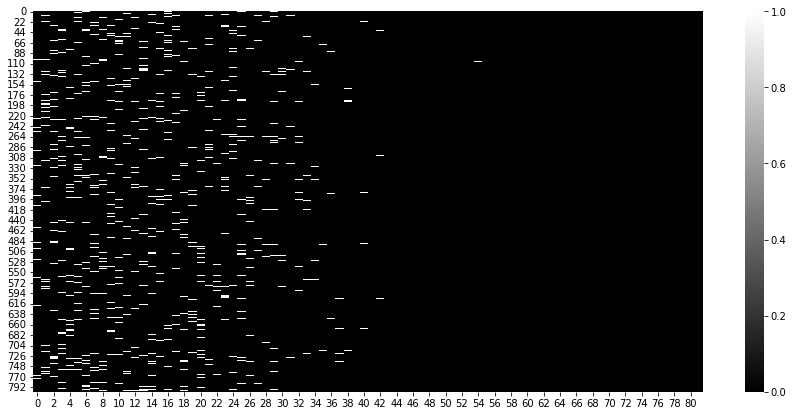

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);